In [ ]:
import io
import pandas as pd
import numpy as np
import csv
from zipfile import ZipFile
import os

In [ ]:
import nltk
# Download the lexicon
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# Import the lexicon 
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
# Create an instance of SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

In [ ]:
appended_data = []
# iterate through all zip files
for filename in os.listdir("hydrated"):
  if filename.endswith(".zip"):
    # unzip each file
    with ZipFile(os.path.join("hydrated", filename)) as zf:
      # if there are multiple files in zip
      for zip_file in zf.namelist():
        print(zip_file)
        # open zip file and read data
        if "__MACOSX" not in zip_file and zip_file.endswith(".csv"):
            with zf.open(zip_file) as z:
              data = pd.read_csv(z, dtype='str', names=["created_at", "full_text", "user_followers", "user_location", "retweets", "favorites", "hashtags"])
              print(data.shape)
              # add each chunk of data to overall list
              appended_data.append(data)
  if filename.endswith(".csv"):
    print(filename)
    data = pd.read_csv(os.path.join("hydrated", filename), dtype='str', names=["created_at", "full_text", "user_followers", "user_location", "retweets", "favorites", "hashtags"])
    print(data.shape)
    # add each chunk of data to overall list
    appended_data.append(data)

# concatenate all data into one dataframe
vaccine_data = pd.concat(appended_data, ignore_index=True)

corona_tweets_101-200.csv
(844594, 7)
corona_tweets_201-300.csv
(873868, 7)
corona_tweets_301-400.csv
(922940, 7)
corona_tweets_401-500.csv
(1098412, 7)
corona_tweets_501-600.csv
(833772, 7)
corona_tweets_601-700.csv
(902540, 7)
corona_tweets_701-800.csv
(1049334, 7)
corona_tweets_801-900.csv
(1054247, 7)
corona_tweets_31-100.csv
(610433, 7)


In [ ]:
# save composite sentiment analysis results as csv
vaccine_data.to_csv('covidvaccinehydrated.csv', quoting=csv.QUOTE_ALL)

In [ ]:
# read in csv data that was already uploaded, and then convert to string
vaccine_data = pd.read_csv('covidvaccinehydrated.csv', dtype='str', index_col=0)
# vaccine_data = pd.read_csv('covidvaccinehydrated.csv', dtype='str', index_col=0)

In [ ]:
# format polarity dictionary values to output as tuple
def format_sentiment_results(scores):
    
    # default polarity classification is neutral
    polarity = "neutral"
    
    # assign each of the polarity scores to variables
    negative = scores['neg']
    neutral = scores['neu']
    positive = scores['pos']
    overall = scores['compound']
    
    # re-assign polarity classification depending on compound value
    if overall >= 0.05:
        polarity = "positive"
    elif overall <= -0.05:
        polarity = "negative"
        
    # returns a tuple of polarity scores as well as the polarity classification
    return negative, neutral, positive, overall, polarity

In [ ]:
# run sentiment analysis on input text
def find_sentiments(data):
    # find polarity scores of each sentence
    scores = sent_analyzer.polarity_scores(data)
    # format output of polarity scores
    return format_sentiment_results(scores)

In [ ]:
keywords = ['vaccine', 'vaccines', 'vax', 'booster', 'dose', 'pfizer', 'moderna', 'johnson', 'j&j']

In [ ]:
# filter for vaccine tweets
filtered = vaccine_data[vaccine_data['full_text'].str.contains('|'.join(keywords), case=False) | vaccine_data['hashtags'].str.contains('|'.join(keywords), case=False)]

In [ ]:
filtered = pd.DataFrame(filtered)

In [ ]:
# reset index before saving to csv and joining with sentiment results
filtered = filtered.reset_index(drop=True)

In [ ]:
filtered.to_csv('filtered.csv', quoting=csv.QUOTE_ALL)

In [ ]:
!cp filtered.csv /content/drive/MyDrive/AIProject

In [ ]:
# read in csv data that was already uploaded, and then convert to string
filtered = pd.read_csv('filtered.csv', dtype='str', index_col=0)

In [ ]:
# find tweets that are not about vaccines
non_vaccine = vaccine_data.drop(filtered.index, axis=0, inplace=False)

In [ ]:
# reset index before saving to csv
non_vaccine = non_vaccine.reset_index(drop=True)

In [ ]:
# save tweets that are not about vaccines to csv
non_vaccine.to_csv('non_vaccine.csv', quoting=csv.QUOTE_ALL)

In [ ]:
# convert text to string so that it can be run through sentiment analysis
filtered['full_text'] = filtered['full_text'].astype('str')

In [ ]:
# gather sentiment analysis results from text
results = filtered['full_text'].apply(find_sentiments)

In [ ]:
# unpack values from list of tuples in sentiment analysis results
unpacked = pd.concat([results.explode()], axis=1).reset_index(drop=True)

In [ ]:
# reshape unpacked values into dataframe with associated columns
sentiments = pd.DataFrame(unpacked.values.reshape(-1, 5), columns=['Negative','Neutral','Positive', 'Overall', 'Polarity'])

In [ ]:
# join sentiment analysis results with vaccine data to make composite dataset
vaccine_data_sentiments = filtered.join(sentiments)

In [ ]:
# save composite sentiment analysis results as csv
vaccine_data_sentiments.to_csv('covidvaccinesentiments.csv', quoting=csv.QUOTE_ALL)

In [ ]:
!cp covidvaccinesentiments.csv /content/drive/MyDrive/AIProject

In [ ]:
# read in csv data that was already uploaded, and then convert to string
vaccine_data_sentiments = pd.read_csv('/content/drive/MyDrive/AIProject/covidvaccinesentiments.csv', dtype='str', index_col=0)

In [ ]:
# replace empty lists in hashtags column with NaN values
vaccine_data_hashtags = vaccine_data_sentiments.copy()
vaccine_data_hashtags = vaccine_data_hashtags.mask(vaccine_data_hashtags.applymap(str).eq('[]'))

In [ ]:
# drop NA values from hashtags
vaccine_data_hashtags = vaccine_data_hashtags.dropna(subset=['hashtags'])

# find hashtags for positive posts
pos_hash = vaccine_data_hashtags[vaccine_data_hashtags['Polarity'] == 'positive']
pos_hashtags = pos_hash['hashtags']

# find hashtags for negative posts
neg_hash = vaccine_data_hashtags[vaccine_data_hashtags['Polarity'] == 'negative']
neg_hashtags = neg_hash['hashtags']

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
# find all hashtags associated with positive tweets
pos_text = ' '.join(hash.split()[1].split("'")[1] for hash in pos_hashtags)
# find all hashtags associated with negative tweets
neg_text = ' '.join(hash.split()[1].split("'")[1] for hash in neg_hashtags)

In [ ]:
import collections

In [ ]:
# make strings of hashtags into lists
pos_list = pos_text.split()
neg_list = neg_text.split()

In [ ]:
# find frequency of words in lists
freq_pos = collections.Counter(pos_list)
freq_neg = collections.Counter(neg_list)

In [ ]:
# find most common hashtags
high_pos = freq_pos.most_common(10)
high_neg = freq_neg.most_common(10)

# sets of positive and negative hashtags
p_tags = set()
n_tags = set()

# add hashtags to sets
for tag in range(10):
  p_tags.add(str.lower(high_pos[tag][0]))
  n_tags.add(str.lower(high_neg[tag][0]))

In [ ]:
# compare hashtags between both sets
common = p_tags & n_tags

In [ ]:
# filter out common hashtags among the two sets of positive and negative hashtags
resultpos = [word for word in pos_list if word.lower() not in common]
resultneg = [word for word in neg_list if word.lower() not in common]

In [ ]:
# remake strings of hashtags with common hashtags removed
pos_text = " ".join(resultpos)
neg_text = " ".join(resultneg)

In [ ]:
# make word cloud of hashtags associated with positive tweets
pos_word_cloud = WordCloud(width=1200, height=900, collocations = False, background_color = 'white').generate(pos_text)
# make word cloud of hashtags associated with negative tweets
neg_word_cloud = WordCloud(width=1200, height=900, collocations = False, background_color = 'white').generate(neg_text)

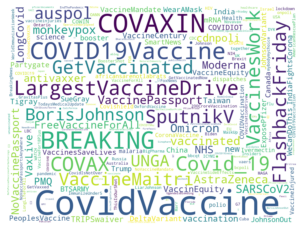

In [ ]:
# plot word cloud of hashtags associated with positive tweets
plt.imshow(pos_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

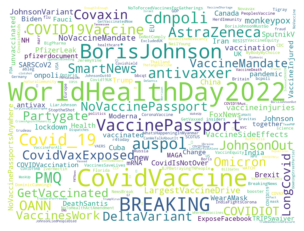

In [ ]:
# word cloud of hashtags associated with negative tweets
plt.imshow(neg_word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# save wordclouds as png
pos_word_cloud.to_file('pos_word_cloud.png')
neg_word_cloud.to_file('neg_word_cloud.png')